In [1]:
import logging
import multiprocessing
import warnings
from itertools import repeat
from pathlib import Path

import astropy.units as u
import click
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.table import Table
from regions import CircleSkyRegion
from scipy.stats import norm

from gammapy.data import GTI, EventList, Observation
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.estimators import ExcessMapEstimator
from gammapy.irf import EnergyDispersion2D, load_cta_irfs
from gammapy.makers import MapDatasetMaker
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import Models, FoVBackgroundModel
from gammapy.utils.table import table_from_row_data

In [2]:
import gammapy
gammapy.__version__

'0.20.1'

In [3]:
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PointSpatialModel,
    DiskSpatialModel,
    GaussianSpatialModel,
    TemplateSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
    PowerLaw2SpectralModel,
    ExpCutoffPowerLaw3FGLSpectralModel,
    SuperExpCutoffPowerLaw4FGLSpectralModel,
    PowerLawNormSpectralModel,
    FoVBackgroundModel,
    TemplateSpectralModel,
)

In [4]:
BASE_PATH = Path("make.py").parent

AVAILABLE_MODELS = [
    "point-pwl",
    "point-ecpl",
    "point-log-parabola",
    "point-pwl2",
    "point-ecpl-3fgl",
    "point-ecpl-4fgl",
    "point-template",
    "diffuse-cube",
    "disk-pwl",
    "gauss-pwl",
]

DPI = 120

# observation config
IRF_FILE = ("$GAMMAPY_DATA/cta-caldb/"+
            "Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz")

POINTING = SkyCoord(0.0, 0.5, frame="galactic", unit="deg")
LIVETIME = 1 * u.hr
GTI_TABLE = GTI.create(start=0 * u.s, stop=LIVETIME.to(u.s))

# dataset config
ENERGY_AXIS = MapAxis.from_energy_bounds("0.1 TeV", "100 TeV", 
                                         nbin=10, per_decade=True)
ENERGY_AXIS_TRUE = MapAxis.from_energy_bounds(
    "0.03 TeV", "300 TeV", nbin=20, per_decade=True, name="energy_true"
)
MIGRA_AXIS = MapAxis.from_bounds(0.5, 2, nbin=150, 
                                 node_type="edges", name="migra")

WCS_GEOM = WcsGeom.create(
    skydir=POINTING, width=(2, 2), binsz=0.02, 
    frame="galactic", axes=[ENERGY_AXIS]
)

In [5]:
irfs = load_cta_irfs(IRF_FILE)
observation = Observation.create(
    obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
)

empty = MapDataset.create(
    WCS_GEOM, energy_axis_true=ENERGY_AXIS_TRUE, migra_axis=MIGRA_AXIS
)
maker = MapDatasetMaker(selection=["exposure", "background", 
                                   "psf", "edisp"])
dataset = maker.run(empty, observation)

filename_dataset = ("/Users/fabiopintore/LAVORO/Gammapy/"+
              "gammapy-benchmarks/validation/event-sampling/"
              +"data/dataset_1h.fits.gz")
dataset.write(filename_dataset, overwrite=True)

In [6]:
#dataset = MapDataset.read(filename_dataset)

filename_events = ("/Users/fabiopintore/LAVORO/Gammapy/"
                  + "gammapy-benchmarks/validation/" +
                    "event-sampling/data/models/point-pwl/" + 
                    "events_1h_0000.fits.gz")
events = EventList.read(filename_events)

counts = Map.from_geom(WCS_GEOM)
counts.fill_events(events)
dataset.counts = counts

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

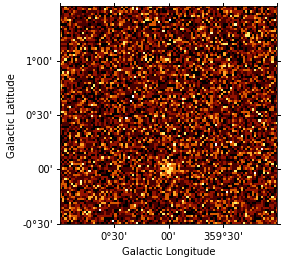

In [7]:
counts.reduce_over_axes().plot()

In [8]:
filename_model = ("/Users/fabiopintore/LAVORO/Gammapy/"
                 +"gammapy-benchmarks/validation/event-sampling/"
                 +"models/point-pwl.yaml")
models = Models.read(filename_model)

models.append(FoVBackgroundModel(dataset_name=dataset.name))

dataset.models = models

In [9]:
spatial_model = PointSpatialModel(lon_0="20.0 deg",
                          lat_0="11.0 deg",
                          frame="galactic")

spectral_model = PowerLawSpectralModel(
                index=2.0,
                amplitude="1e-12 TeV-1 cm-2 s-1",
                reference="1 TeV"
                )

sky_model = SkyModel(spectral_model = spectral_model,
             spatial_model = spatial_model,
             name="test_source")

models = Models([sky_model, FoVBackgroundModel(dataset_name=dataset.name)])

In [10]:
dataset.models = models
print(dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : test_source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.000   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :     20.000   +/-    0.00 deg         
    lat_0                         :     11.000   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : imVKP5HW-bkg
  Datasets names            : ['imVKP5HW']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.00

In [11]:
#dataset.fake()

In [12]:
fit = Fit()
result = fit.run(dataset)

Position <SkyCoord (Galactic): (l, b) in deg
    (20., 11.)> is outside valid IRF map range, using nearest IRF defined within


In [15]:
models[0].spectral_model.plot?

Signature:
spectral_model.plot(
    energy_bounds,
    ax=None,
    sed_type='dnde',
    energy_power=0,
    n_points=100,
    **kwargs,
)
Docstring:
Plot spectral model curve.

kwargs are forwarded to `matplotlib.pyplot.plot`

By default a log-log scaling of the axes is used, if you want to change
the y axis scaling to linear you can use::

    from gammapy.modeling.models import ExpCutoffPowerLawSpectralModel
    from astropy import units as u

    pwl = ExpCutoffPowerLawSpectralModel()
    ax = pwl.plot(energy_bounds=(0.1, 100) * u.TeV)
    ax.set_yscale('linear')

Parameters
----------
ax : `~matplotlib.axes.Axes`, optional
    Axis
energy_bounds : `~astropy.units.Quantity`
    Plot energy bounds passed to MapAxis.from_energy_bounds
sed_type : {"dnde", "flux", "eflux", "e2dnde"}
    Evaluation methods of the model
energy_power : int, optional
    Power of energy to multiply flux axis with
n_points : int, optional
    Number of evaluation nodes
**kwargs : dict
    Keyword arguments 

In [4]:
POINTING = SkyCoord(70.0, 0.5, frame="galactic", unit="deg")
LIVETIME = 10 * u.hr

IRF_FILE = ("$GAMMAPY_DATA/cta-caldb/"+
            "Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz")
irfs = load_cta_irfs(IRF_FILE)

In [5]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_bounds(0.5, 200, nbin=20, unit="TeV", name="energy", interp="log")
geom = WcsGeom.create(
    skydir=POINTING,
    binsz=0.02,
    width=(3, 3),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_bounds(0.1, 300, nbin=30, unit="TeV", name="energy_true", interp="log")

empty = MapDataset.create(
    geom, name="dataset-simu", energy_axis_true=energy_true
)

In [6]:
obs = Observation.create(
    pointing=POINTING, livetime=LIVETIME, irfs=irfs,
)

In [7]:
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
dataset = maker.run(empty, obs)

In [8]:
spatial_model = PointSpatialModel(lon_0="70.0 deg",
                          lat_0="1.0 deg",
                          frame="galactic")

spectral_model = PowerLawSpectralModel(
                index=2.0,
                amplitude="1e-12 TeV-1 cm-2 s-1",
                reference="1 TeV"
                )

sky_model = SkyModel(spectral_model = spectral_model,
             spatial_model = spatial_model,
             name="test_source")

models = Models([sky_model, FoVBackgroundModel(dataset_name=dataset.name)])

In [9]:
dataset.models = models
dataset.fake()

In [10]:
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 22691 
  Total background counts         : 22130.77
  Total excess counts             : 560.23

  Predicted counts                : 22798.67
  Predicted background counts     : 22130.77
  Predicted excess counts         : 667.89

  Exposure min                    : 6.35e+09 m2 s
  Exposure max                    : 1.37e+11 m2 s

  Number of total bins            : 450000 
  Number of fit bins              : 450000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 128737.87

  Number of models                : 2 
  Number of parameters            : 8
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : test_source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
     

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

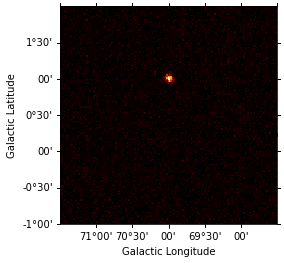

In [11]:
dataset.counts.sum_over_axes().plot()

In [12]:
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[dataset])

Position <SkyCoord (Galactic): (l, b) in deg
    (71.75196279, 1.)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (71.75196279, 1.)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (68.24803721, 1.)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (68.24803721, 1.)> is outside valid IRF map range, using nearest IRF defined within
